# Step 1. EDA

In [109]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
#Import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

## Class for dealing to data sets
from src.DatasetManager import DatasetManager
## Class for dealing models
from src.ModelManager import ModelManager
## Class for dealing with common dataset processing tasks
from src.DatasetProcesser import DatasetProcessor, HFprocesser

In [111]:
dataset_manager = DatasetManager()
financial_news = dataset_manager.get_financial_news() #read csv set header to none because columns have no title


In [112]:
#Check DF head and Tail
financial_news.head()
financial_news.tail()

,label,news
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...
4845,negative,Sales in Finland decreased by 10.5 % in Januar...


In [113]:
#Check shape of train df
financial_news.shape

(4846, 2)

In [114]:
#Check information of df
#we can see there is no missing values 
financial_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   news    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


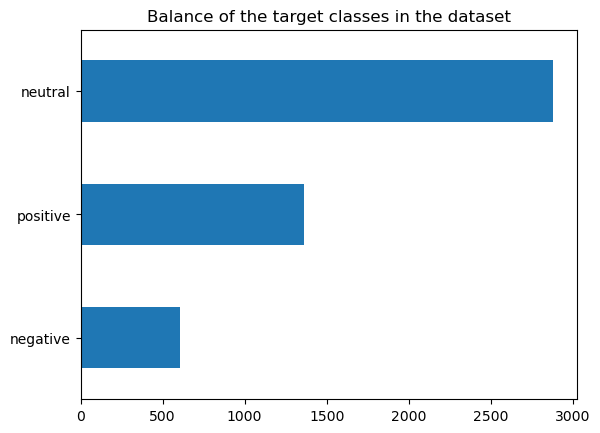

neutral     2879
positive    1363
negative     604
Name: label, dtype: int64


In [115]:
#Check balance of the data set
dataset_manager.plot_external(financial_news)

#We can notice that the data set is imbalanced


In [116]:
#Check the maximum lenght of the documents
print(dataset_manager.check_doc_len(financial_news))

81


# Step 2. Pre-processing

### Approach 1. do not balance classes

In [117]:
#First let's map the labels to integers
fin_news_preprocessor = DatasetProcessor(financial_news)
label_map = {'negative': 2, 'neutral': 0, 'positive': 1}

fin_news_preprocessor.map_labels(label_map)

#The preprocessors df can directly be used thanks to __getattr__ method
fin_news_preprocessor.head()

,label,news,len
0,0,"According to Gran , the company has no plans t...",25
1,0,Technopolis plans to develop in stages an area...,31
2,2,The international electronic industry company ...,36
3,1,With the new production plant the company woul...,33
4,1,According to the company 's updated strategy f...,41


In [118]:
financial_news.drop(columns={'len'}, inplace=True)
financial_news.head(3)

,label,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...


In [119]:
#Save approach 1 dataframe to folder
fin_news_preprocessor.to_csv('data/financial_news_1.csv', index=False)

### Approach 2. Downsampling

In [120]:
# Let's downsample positive and neutral labels to create a balanced data set

financial_news_ds = dataset_manager.get_financial_news() 
fin_news_preprocessor = DatasetProcessor(financial_news_ds)
fin_news_preprocessor.map_labels()

#Now let's separate our 3 classes to perform downsample
financial_news_n,financial_news_0,financial_news_1 = fin_news_preprocessor.seperate_labels_classes()



In [121]:
#Check separated labels
financial_news_n['label'].unique()
financial_news_0['label'].unique()
financial_news_1['label'].unique()

array([1], dtype=int64)

In [122]:
#Downsample positive and neutral labels to be same length as negative label
financial_news_0, financial_news_1 = fin_news_preprocessor.downsample_labels(financial_news_n, financial_news_0, financial_news_1)


In [123]:
#Check shapes
financial_news_0['label'].shape
financial_news_1['label'].shape

(604,)

In [124]:
#put everything together again
#shuffle rows and reset index
financial_news_ds = fin_news_preprocessor.shuffle_and_reset([financial_news_n, financial_news_0, financial_news_1])

#check df
financial_news_ds.tail()

,label,news
1807,0,LSC 's 30 employees will move to Ixonos with t...
1808,0,BasWare Order Matching automatically matches p...
1809,2,The result will also be burdened by increased ...
1810,2,"( ADPnews ) - May 4 , 2010 - Finnish cutlery a..."
1811,0,During the past 10 years the factory has produ...


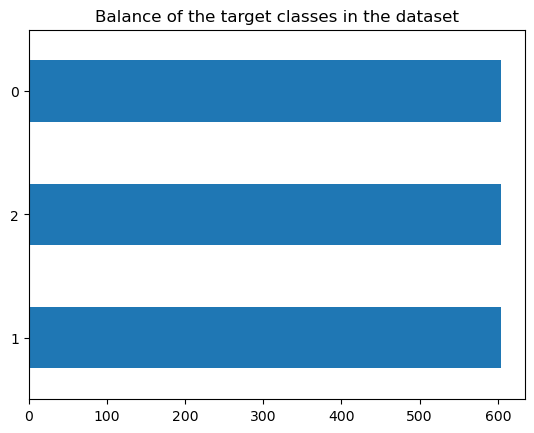

1    604
2    604
0    604
Name: label, dtype: int64


In [125]:
#Check balance of the data set

dataset_manager.plot_external(financial_news_ds)

#We can notice that the data set is balanced


In [126]:
#save approach 2 dataframe 
financial_news_ds.to_csv('data/financial_news_2.csv', index=False)

# Step 3. Feature extraction

## Feature Extraction for Training an LSTM model from scratch

In [127]:
#For this approach we will use Word2Vec Google negative 300 bin file. 
#Since this file was trained on news it should make sense to make feature extraction for news headlines
#import libraries
from gensim.models import Word2Vec, KeyedVectors
data_path = 'data/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(data_path, binary=True)

In [128]:
# Use the data set manager to load data frames for use with keras
dataset_manager.load_processed('imbalanced','data/financial_news_1.csv')
dataset_manager.load_processed('balanced','data/financial_news_2.csv')

In [129]:
#Read data sets

dataset_manager['balanced'].head()

,label,news
0,1,Shares of Standard Chartered ( STAN ) rose 1.2...
1,2,It is a disappointment to see the plan folded .
2,2,"In the fourth quarter of 2008 , net sales decr..."
3,2,JP Morgan expects that Scala will lower Nobel ...
4,0,Honkarakenne mainly exports large luxury log h...


In [130]:
#Get a list of list of the news cleaned from non alphabet characters
list_of_list_news_1 = dataset_manager['balanced'].get_list_of_news()
list_of_list_news_2 = dataset_manager['imbalanced'].get_list_of_news()


In [131]:
list_of_list_news_1[0]

['Shares',
 'of',
 'Standard',
 'Chartered',
 '(',
 'STAN',
 ')',
 'rose',
 '1.2',
 '%',
 'in',
 'the',
 'FTSE',
 '100',
 ',',
 'while',
 'Royal',
 'Bank',
 'of',
 'Scotland',
 '(',
 'RBS',
 ')',
 'shares',
 'rose',
 '2',
 '%',
 'and',
 'Barclays',
 'shares',
 '(',
 'BARC',
 ')',
 '(',
 'BCS',
 ')',
 'were',
 'up',
 '1.7',
 '%',
 '.']

In [132]:
#Clean each new from non alphabet characters
re_list_of_lists_1 = dataset_manager['balanced'].clean_lists(list_of_list_news_1)
re_list_of_lists_2 = dataset_manager['imbalanced'].clean_lists(list_of_list_news_2)

In [133]:
re_list_of_lists_1[0]

['Shares',
 'of',
 'Standard',
 'Chartered',
 'STAN',
 'rose',
 'in',
 'the',
 'FTSE',
 'while',
 'Royal',
 'Bank',
 'of',
 'Scotland',
 'RBS',
 'shares',
 'rose',
 'and',
 'Barclays',
 'shares',
 'BARC',
 'BCS',
 'were',
 'up']

In [134]:
w2v_embbedings_1 = dataset_manager['balanced'].embbeding_word_feats(re_list_of_lists_1,word2vec_model)
w2v_embbedings_2 = dataset_manager['imbalanced'].embbeding_word_feats(re_list_of_lists_2,word2vec_model)


In [135]:
#Sanity checkk
print(len(w2v_embbedings_1))
print(len(w2v_embbedings_1[0]))
print(len(w2v_embbedings_1[0][1]))

1812
21
300


In [136]:

#Check the maximum number of tokens in documents across the corpus
temp_1 = [len(w2v_embbedings_1[i]) for i in range(len(w2v_embbedings_1))]
print(max(temp_1))

temp_2 = [len(w2v_embbedings_2[i]) for i in range(len(w2v_embbedings_2))]
print(max(temp_2))

45
45


In [137]:
w2v_embbedings_1 = dataset_manager['balanced'].padding_embeddings(w2v_embbedings_1, pad_to=45)
w2v_embbedings_2 = dataset_manager['imbalanced'].padding_embeddings(w2v_embbedings_2, pad_to=45)

In [138]:
#Sanity checkk
print(len(w2v_embbedings_2))
print(len(w2v_embbedings_2[0]))
print(len(w2v_embbedings_2[0][1]))

4846
45
300


In [139]:
## This gets word embeddings from the words in the balanced dataset
embeddings = dataset_manager['balanced'].get_embeddings(word2vec_model=word2vec_model)
## this splits the dataset into test train validation data
balanced_tvt_dict = dataset_manager['balanced'].train_val_test_split(embeddings)

embeddings = dataset_manager['imbalanced'].get_embeddings(word2vec_model=word2vec_model)
imbalanced_tvt_dict = dataset_manager['imbalanced'].train_val_test_split(embeddings)

## init a model manager object that is capable of running models
model_manager = ModelManager() 
## the model manager class is capable of taking in a configuration dictionary



# Step 4 Training

### Approach 2. Train an LSTM model from scratch

In [140]:

#Define LSTM architechture for balanced dataset
model_config_1 = {
    'model_name': 'LSTM_Model_1',
    'units': 32,
    'dropout_rate': 0.2,
    'return_sequences_config': False,
    'dense_units': 3,
    'activation': 'sigmoid',
    'output_activation': 'softmax',
    'optimizer': 'adam',
    'loss': 'categorical_crossentropy',
    'epochs': 100,
    'batch_size': 32,
}

In [141]:
model_manager.run_model_config(balanced_tvt_dict, model_config_1)


Epoch 1/100
46/46 [==============================] - 1s 14ms/step - loss: 1.1362 - accuracy: 0.3320 - val_loss: 1.0988 - val_accuracy: 0.3462
Epoch 2/100
46/46 [==============================] - 0s 11ms/step - loss: 1.1087 - accuracy: 0.3499 - val_loss: 1.1007 - val_accuracy: 0.3407
Epoch 3/100
46/46 [==============================] - 1s 12ms/step - loss: 1.1107 - accuracy: 0.3485 - val_loss: 1.1001 - val_accuracy: 0.3407
Epoch 4/100
46/46 [==============================] - 1s 11ms/step - loss: 1.1167 - accuracy: 0.3299 - val_loss: 1.0984 - val_accuracy: 0.3462
Epoch 5/100
46/46 [==============================] - 1s 11ms/step - loss: 1.1168 - accuracy: 0.3326 - val_loss: 1.0984 - val_accuracy: 0.3462
Epoch 6/100
46/46 [==============================] - 0s 11ms/step - loss: 1.1111 - accuracy: 0.3409 - val_loss: 1.1016 - val_accuracy: 0.3407
Epoch 7/100
46/46 [==============================] - 0s 11ms/step - loss: 1.1175 - accuracy: 0.3230 - val_loss: 1.1020 - val_accuracy: 0.3132
Epoch 

In [142]:
#Define LSTM architechture for imbalanced dataset
model_config_2 = {
    'model_name': 'LSTM_Model_2',
    'units': 32,
    'dropout_rate': 0.2,
    'return_sequences_config': False,
    'dense_units': 3,
    'activation': 'sigmoid',
    'output_activation': 'softmax',
    'optimizer': 'adam',
    'loss': 'categorical_crossentropy',
    'epochs': 30,
    'batch_size': 10,
    'metrics': ['accuracy'],
}

In [143]:
model_manager.run_model_config(imbalanced_tvt_dict, model_config_2)


Epoch 1/30
388/388 [==============================] - 3s 6ms/step - loss: 0.9593 - accuracy: 0.5751 - val_loss: 0.9359 - val_accuracy: 0.5773
Epoch 2/30
388/388 [==============================] - 2s 5ms/step - loss: 0.9418 - accuracy: 0.5942 - val_loss: 0.9345 - val_accuracy: 0.5773
Epoch 3/30
388/388 [==============================] - 2s 5ms/step - loss: 0.9347 - accuracy: 0.5952 - val_loss: 0.9317 - val_accuracy: 0.5773
Epoch 4/30
388/388 [==============================] - 2s 5ms/step - loss: 0.9337 - accuracy: 0.5955 - val_loss: 0.9332 - val_accuracy: 0.5773
Epoch 5/30
388/388 [==============================] - 2s 6ms/step - loss: 0.9312 - accuracy: 0.5955 - val_loss: 0.9295 - val_accuracy: 0.5773
Epoch 6/30
388/388 [==============================] - 2s 5ms/step - loss: 0.9316 - accuracy: 0.5955 - val_loss: 0.9298 - val_accuracy: 0.5773
Epoch 7/30
388/388 [==============================] - 2s 5ms/step - loss: 0.9251 - accuracy: 0.5955 - val_loss: 0.9212 - val_accuracy: 0.5773
Epoch 

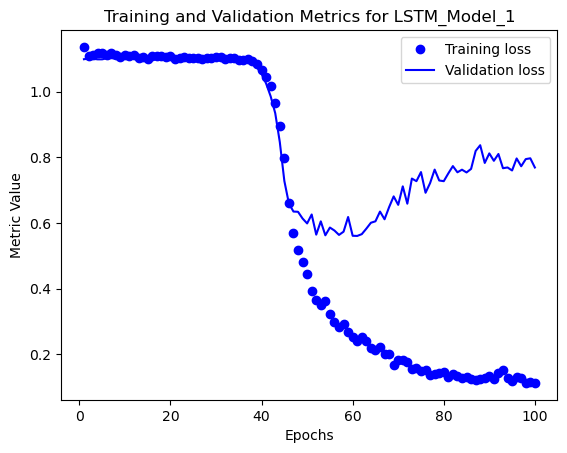

In [148]:
model_manager.plot_model_history('LSTM_Model_1')


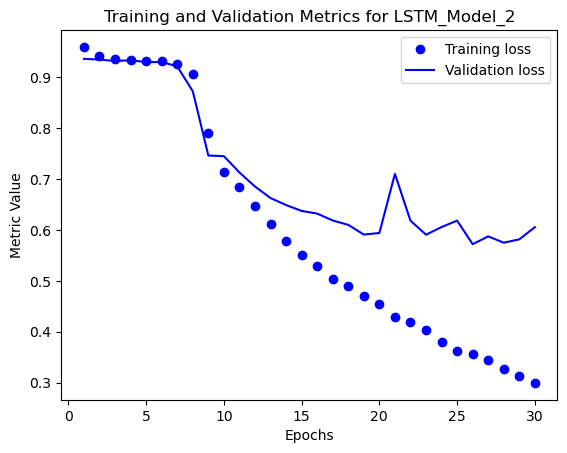

In [149]:
model_manager.plot_model_history('LSTM_Model_2')


# Step 5 Evaluation

In [146]:
## The model manager can be used to make a prediction
## and out metrics
y_pred_1 = model_manager.predict('LSTM_Model_1', balanced_tvt_dict['X_test'], return_class_indices=True)
model_manager.print_performance_metrics('LSTM_Model_1', balanced_tvt_dict['y_test'], y_pred_1, dataset_type='Imbalanced')


y_pred_2 = model_manager.predict('LSTM_Model_2', imbalanced_tvt_dict['X_test'], return_class_indices=True)
model_manager.print_performance_metrics('LSTM_Model_2', imbalanced_tvt_dict['y_test'], y_pred_2, dataset_type='Imbalanced')



6/6 [==============================] - 0s 8ms/step
Accuracy Imbalanced data set for LSTM_Model_1: 0.82
F1 Score Imbalanced data set for LSTM_Model_1: 0.82
16/16 [==============================] - 0s 6ms/step
Accuracy Imbalanced data set for LSTM_Model_2: 0.76
F1 Score Imbalanced data set for LSTM_Model_2: 0.77


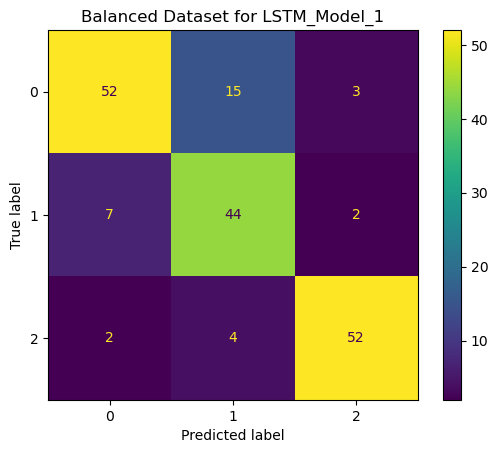

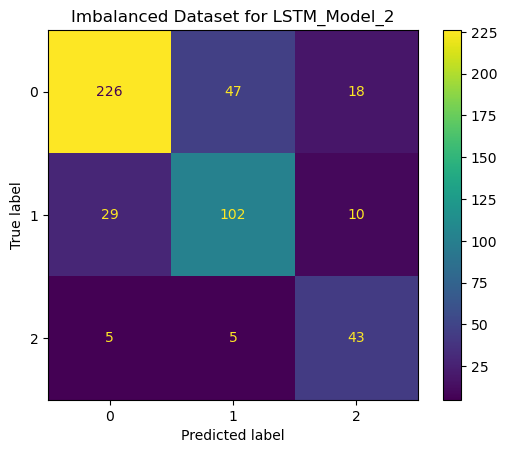

In [147]:
#You can also plot the confusion matrix
y_test_1_indices = balanced_tvt_dict['y_test'].argmax(axis=1)
model_manager.plot_confusion_matrix('LSTM_Model_1', y_test_1_indices, y_pred_1, title='Balanced Dataset')


y_test_2_indices = imbalanced_tvt_dict['y_test'].argmax(axis=1)
model_manager.plot_confusion_matrix('LSTM_Model_2', y_test_2_indices, y_pred_2, title='Imbalanced Dataset')
